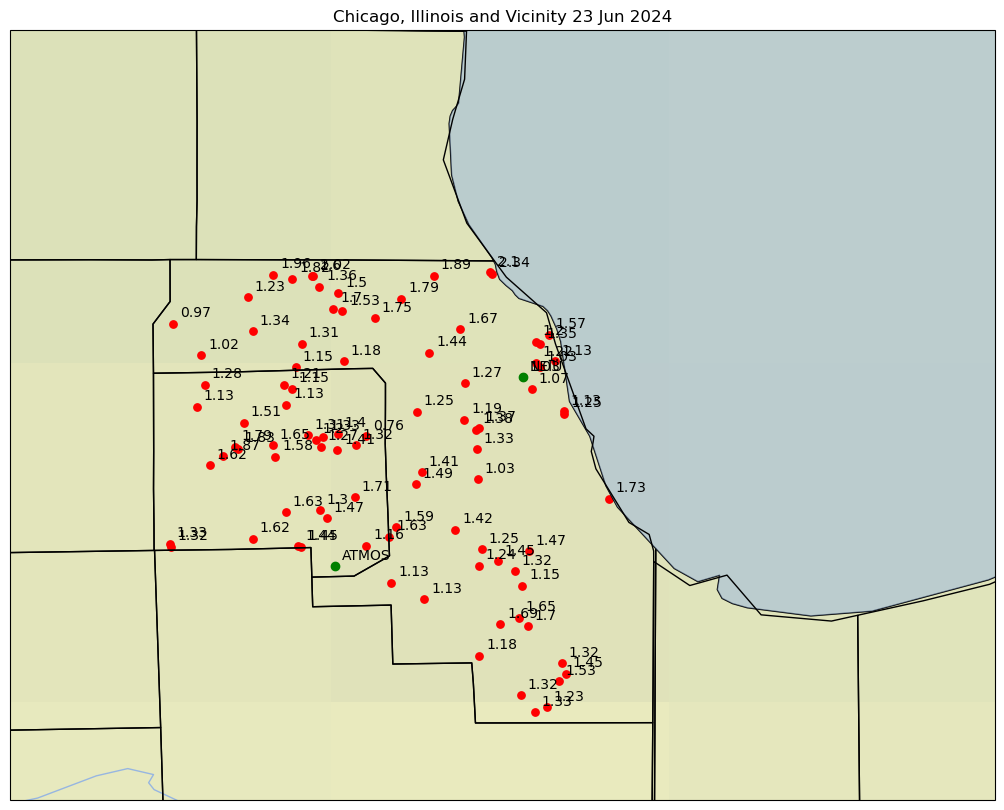

In [21]:
import warnings
import matplotlib.pyplot as plt
import numpy as np
from cartopy import crs as ccrs, feature as cfeature
import cartopy.io.shapereader as shpreader
import pandas as pd
from metpy.plots import USCOUNTIES

date_selection = "06/23/2024"

file_sat = f'http://data.cocorahs.org/export/exportreports.aspx?ReportType=Daily&dtf=1&Format=CSV&State=IL&County=DP&ReportDateType=reportdate&Date={date_selection}&TimesInGMT=True'
file_sat2 = f'http://data.cocorahs.org/export/exportreports.aspx?ReportType=Daily&dtf=1&Format=CSV&State=IL&County=CK&ReportDateType=reportdate&Date={date_selection}&TimesInGMT=True'


def rain_plot(filepath, filepath2, output_file):
    # Read the CSV files into DataFrames
    df1 = pd.read_csv(filepath)
    df2 = pd.read_csv(filepath2)
    
    
    figure = plt.figure(figsize=(16, 10))
    ax = figure.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
    
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.STATES)
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.add_feature(cfeature.LAND)
    ax.add_feature(cfeature.OCEAN)
    ax.add_feature(cfeature.LAKES, alpha=0.5)
    ax.add_feature(cfeature.RIVERS)
    ax.add_feature(USCOUNTIES)
    
    # Sort the times, convert to datetime, and extract the day, month, and year
    year_month_day = pd.to_datetime(df1.sort_values('ObservationDate', ascending=False).ObservationDate.values[0]).strftime('%d %b %Y')
    ax.set_title(f'Chicago, Illinois and Vicinity {year_month_day}')
    ax.set_extent([-88.474769, -87.020042, 41.356063, 42.493302])
    ax.stock_img()
    
    crs = ccrs.PlateCarree()
    WAGGLE_SITES = {
        'NEIU': [41.980289109, -87.71703552],
        'ATMOS': [41.701605152, -87.995196552]
    }
    ax.plot(WAGGLE_SITES["ATMOS"][1], WAGGLE_SITES["ATMOS"][0], color="Green", marker="o", transform=ccrs.PlateCarree())
    ax.text(WAGGLE_SITES["ATMOS"][1] + 0.01, WAGGLE_SITES["ATMOS"][0] + 0.01, "ATMOS", color="Black", transform=ccrs.PlateCarree())
    ax.plot(WAGGLE_SITES["NEIU"][1], WAGGLE_SITES["NEIU"][0], color="Green", marker="o", transform=ccrs.PlateCarree())
    ax.text(WAGGLE_SITES["NEIU"][1] + 0.01, WAGGLE_SITES["NEIU"][0] + 0.01, "NEIU", color="Black", transform=ccrs.PlateCarree())
    
    # Plot the data from both DataFrames
    for df in [df1, df2]:
        for i in range(len(df["Longitude"])):
            ax.text(df["Longitude"][i] + 0.01, df["Latitude"][i] + 0.01, df["TotalPrecipAmt"][i], color="Black", transform=ccrs.PlateCarree())
        plt.scatter(
            x=df["Longitude"],
            y=df["Latitude"],
            color="red",
            s=28,
            alpha=1,
            transform=ccrs.PlateCarree()
        )
    
    # Save the plot as an image file
    plt.savefig(output_file, bbox_inches='tight')
    plt.show()

# Call the function with both file paths and specify the output file name
rain_plot(file_sat, file_sat2, 'rainfall_plot.png')


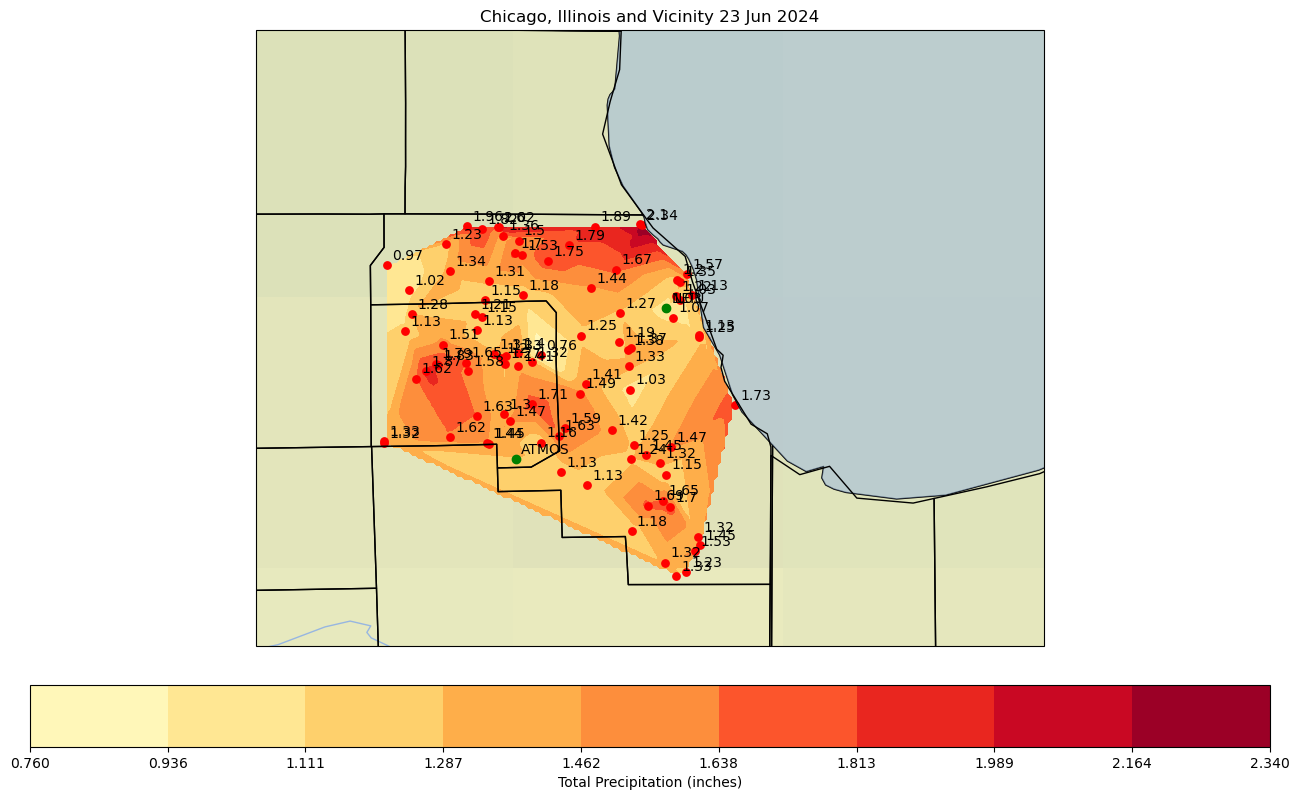

In [34]:
import warnings
import matplotlib.pyplot as plt
import numpy as np
from cartopy import crs as ccrs, feature as cfeature
import cartopy.io.shapereader as shpreader
import pandas as pd
from metpy.plots import USCOUNTIES
from scipy.interpolate import griddata

date_selection = "06/23/2024"

file_sat = f'http://data.cocorahs.org/export/exportreports.aspx?ReportType=Daily&dtf=1&Format=CSV&State=IL&County=DP&ReportDateType=reportdate&Date={date_selection}&TimesInGMT=True'
file_sat2 = f'http://data.cocorahs.org/export/exportreports.aspx?ReportType=Daily&dtf=1&Format=CSV&State=IL&County=CK&ReportDateType=reportdate&Date={date_selection}&TimesInGMT=True'

def rain_plot(filepath, filepath2, output_file):
    # Read the CSV files into DataFrames
    df1 = pd.read_csv(filepath)
    df2 = pd.read_csv(filepath2)
    
    figure = plt.figure(figsize=(16, 10))
    ax = figure.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
    
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.STATES)
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.add_feature(cfeature.LAND)
    ax.add_feature(cfeature.OCEAN)
    ax.add_feature(cfeature.LAKES, alpha=0.5)
    ax.add_feature(cfeature.RIVERS)
    ax.add_feature(USCOUNTIES)
    
    # Sort the times, convert to datetime, and extract the day, month, and year
    year_month_day = pd.to_datetime(df1.sort_values('ObservationDate', ascending=False).ObservationDate.values[0]).strftime('%d %b %Y')
    ax.set_title(f'Chicago, Illinois and Vicinity {year_month_day}')
    ax.set_extent([-88.474769, -87.020042, 41.356063, 42.493302])
    ax.stock_img()
    
    crs = ccrs.PlateCarree()
    WAGGLE_SITES = {
        'NEIU': [41.980289109, -87.71703552],
        'ATMOS': [41.701605152, -87.995196552]
    }
    ax.plot(WAGGLE_SITES["ATMOS"][1], WAGGLE_SITES["ATMOS"][0], color="Green", marker="o", transform=ccrs.PlateCarree())
    ax.text(WAGGLE_SITES["ATMOS"][1] + 0.01, WAGGLE_SITES["ATMOS"][0] + 0.01, "ATMOS", color="Black", transform=ccrs.PlateCarree())
    ax.plot(WAGGLE_SITES["NEIU"][1], WAGGLE_SITES["NEIU"][0], color="Green", marker="o", transform=ccrs.PlateCarree())
    ax.text(WAGGLE_SITES["NEIU"][1] + 0.01, WAGGLE_SITES["NEIU"][0] + 0.01, "NEIU", color="Black", transform=ccrs.PlateCarree())
    
    # Combine data from both DataFrames
    combined_df = pd.concat([df1, df2])
    
    # Interpolate the data to create a grid for contour plotting
    lon = combined_df['Longitude'].values
    lat = combined_df['Latitude'].values
    precip = combined_df['TotalPrecipAmt'].values
    
    # Create grid
    grid_lon, grid_lat = np.meshgrid(
        np.linspace(lon.min(), lon.max(), 100),
        np.linspace(lat.min(), lat.max(), 100)
    )
    
    # Interpolate rainfall data
    grid_precip = griddata((lon, lat), precip, (grid_lon, grid_lat), method='linear')
    
    # Plot the contourf
    contour = ax.contourf(grid_lon, grid_lat, grid_precip, levels=np.linspace(precip.min(), precip.max(), 10), cmap='YlOrRd', transform=ccrs.PlateCarree())
    plt.colorbar(contour, ax=ax, orientation='horizontal', pad=0.05, label='Total Precipitation (inches)')
    
    # Plot the original data points
    for i in range(len(combined_df)):
        ax.text(combined_df["Longitude"].values[i] + 0.01, combined_df["Latitude"].values[i] + 0.01, combined_df["TotalPrecipAmt"].values[i], color="Black", transform=ccrs.PlateCarree())
    plt.scatter(
        x=combined_df["Longitude"],
        y=combined_df["Latitude"],
        color="red",
        s=28,
        alpha=1,
        transform=ccrs.PlateCarree()
    )
    
    # Save the plot as an image file
    plt.savefig(output_file, bbox_inches='tight')
    plt.show()

# Call the function with both file paths and specify the output file name
rain_plot(file_sat, file_sat2, 'rainfall_plot_TEST.png')


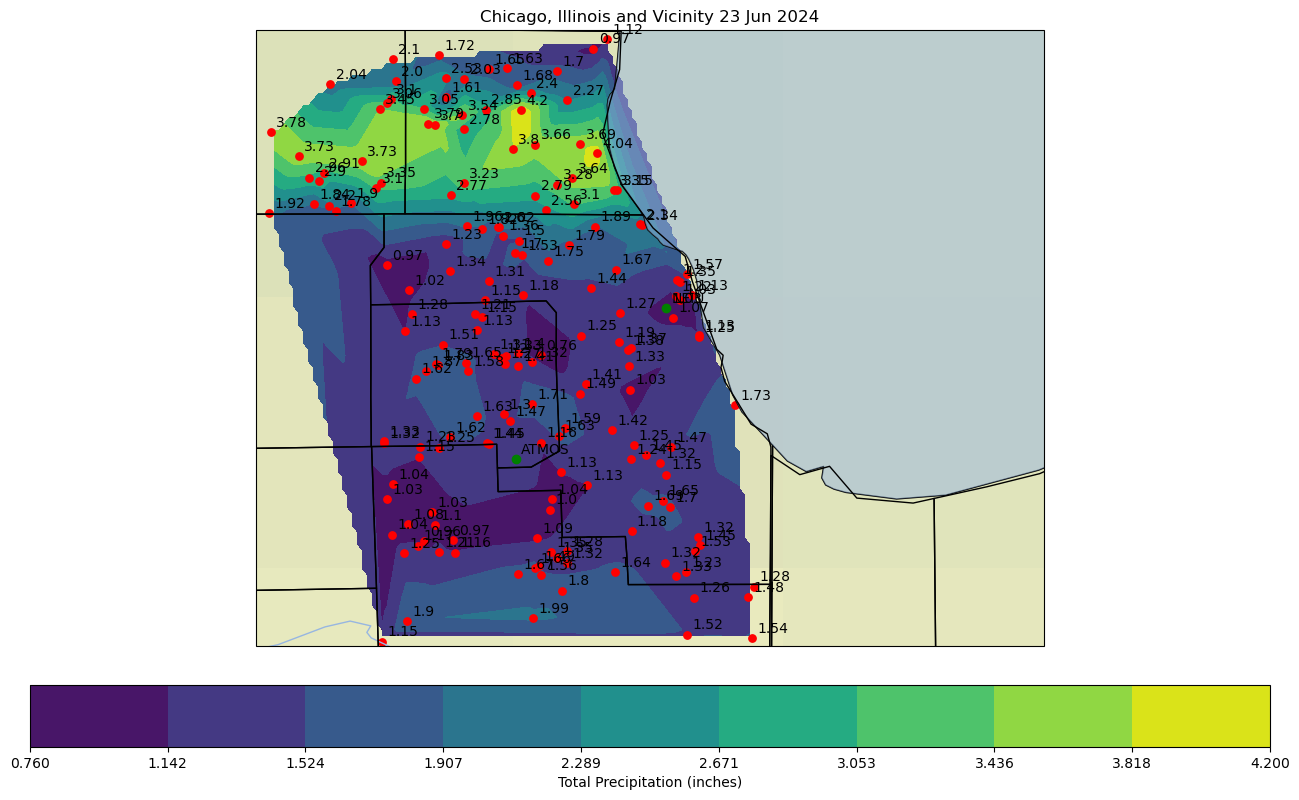

In [71]:
import warnings
import matplotlib.pyplot as plt
import numpy as np
from cartopy import crs as ccrs, feature as cfeature
import cartopy.io.shapereader as shpreader
import pandas as pd
from metpy.plots import USCOUNTIES
from scipy.interpolate import griddata
import cmweather

date_selection = "06/23/2024"

file_sat = f'http://data.cocorahs.org/export/exportreports.aspx?ReportType=Daily&dtf=1&Format=CSV&State=IL&County=DP&ReportDateType=reportdate&Date={date_selection}&TimesInGMT=True'
file_sat2 = f'http://data.cocorahs.org/export/exportreports.aspx?ReportType=Daily&dtf=1&Format=CSV&State=IL&County=CK&ReportDateType=reportdate&Date={date_selection}&TimesInGMT=True'
file_sat3 = f'http://data.cocorahs.org/export/exportreports.aspx?ReportType=Daily&dtf=1&Format=CSV&State=IL&County=MCH&ReportDateType=reportdate&Date={date_selection}&TimesInGMT=True'
file_sat4 = f'http://data.cocorahs.org/export/exportreports.aspx?ReportType=Daily&dtf=1&Format=CSV&State=IL&County=WL&ReportDateType=reportdate&Date={date_selection}&TimesInGMT=True'
file_sat5 = f'http://data.cocorahs.org/export/exportreports.aspx?ReportType=Daily&dtf=1&Format=CSV&State=IL&County=LK&ReportDateType=reportdate&Date={date_selection}&TimesInGMT=True'
file_sat6 = f'http://data.cocorahs.org/export/exportreports.aspx?ReportType=Daily&dtf=1&Format=CSV&State=IL&County=DK&ReportDateType=reportdate&Date={date_selection}&TimesInGMT=True'
def rain_plot(filepath, filepath2, filepath3, filepath4, filepath5, filepath6,output_file):
    # Read the CSV files into DataFrames
    df1 = pd.read_csv(filepath)
    df2 = pd.read_csv(filepath2)
    df3 = pd.read_csv(filepath3)
    df4 = pd.read_csv(filepath4)
    df5 = pd.read_csv(filepath5)
    df6 = pd.read_csv(filepath6)
    
    figure = plt.figure(figsize=(16, 10))
    ax = figure.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
    
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.STATES)
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.add_feature(cfeature.LAND)
    ax.add_feature(cfeature.OCEAN)
    ax.add_feature(cfeature.LAKES, alpha=0.5)
    ax.add_feature(cfeature.RIVERS)
    ax.add_feature(USCOUNTIES)
    
    # Sort the times, convert to datetime, and extract the day, month, and year
    year_month_day = pd.to_datetime(df1.sort_values('ObservationDate', ascending=False).ObservationDate.values[0]).strftime('%d %b %Y')
    ax.set_title(f'Chicago, Illinois and Vicinity {year_month_day}')
    ax.set_extent([-88.474769, -87.020042, 41.356063, 42.493302])
    ax.stock_img()
    
    crs = ccrs.PlateCarree()
    WAGGLE_SITES = {
        'NEIU': [41.980289109, -87.71703552],
        'ATMOS': [41.701605152, -87.995196552]
    }
    ax.plot(WAGGLE_SITES["ATMOS"][1], WAGGLE_SITES["ATMOS"][0], color="Green", marker="o", transform=ccrs.PlateCarree())
    ax.text(WAGGLE_SITES["ATMOS"][1] + 0.01, WAGGLE_SITES["ATMOS"][0] + 0.01, "ATMOS", color="Black", transform=ccrs.PlateCarree())
    ax.plot(WAGGLE_SITES["NEIU"][1], WAGGLE_SITES["NEIU"][0], color="Green", marker="o", transform=ccrs.PlateCarree())
    ax.text(WAGGLE_SITES["NEIU"][1] + 0.01, WAGGLE_SITES["NEIU"][0] + 0.01, "NEIU", color="Black", transform=ccrs.PlateCarree())
    
    # Combine data from both DataFrames
    combined_df = pd.concat([df1, df2, df3, df4, df5, df6])
    
    # Filter data within the specified extent
    combined_df = combined_df[
        (combined_df['Longitude'] >= -88.474769) &
        (combined_df['Longitude'] <= -87.020042) &
        (combined_df['Latitude'] >= 41.356063) &
        (combined_df['Latitude'] <= 42.493302)
    ]
    
    # Interpolate the data to create a grid for contour plotting
    lon = combined_df['Longitude'].values
    lat = combined_df['Latitude'].values
    precip = combined_df['TotalPrecipAmt'].values
    
    # Create grid
    grid_lon, grid_lat = np.meshgrid(
        np.linspace(lon.min(), lon.max(), 100),
        np.linspace(lat.min(), lat.max(), 100)
    )
    
    # Interpolate rainfall data
    grid_precip = griddata((lon, lat), precip, (grid_lon, grid_lat), method='linear')
    
    # Plot the contourf
    contour = ax.contourf(grid_lon, grid_lat, grid_precip, levels=np.linspace(precip.min(), precip.max(), 10), cmap='viridis', transform=ccrs.PlateCarree())
    plt.colorbar(contour, ax=ax, orientation='horizontal', pad=0.05, label='Total Precipitation (inches)')
    
    # Plot the original data points
    for i in range(len(combined_df)):
        ax.text(combined_df["Longitude"].values[i] + 0.01, combined_df["Latitude"].values[i] + 0.01, combined_df["TotalPrecipAmt"].values[i], color="Black", transform=ccrs.PlateCarree())
    plt.scatter(
        x=combined_df["Longitude"],
        y=combined_df["Latitude"],
        color="red",
        s=28,
        alpha=1,
        transform=ccrs.PlateCarree()
    )
    
    # Save the plot as an image file
    plt.savefig(output_file, bbox_inches='tight')
    plt.show()

# Call the function with both file paths and specify the output file name
rain_plot(file_sat, file_sat2, file_sat3, file_sat4, file_sat5, file_sat6, 'rainfall_plot_TEST.png')
